## Exercise 1 ##
For the Boston housing dataset, construct a dataframe with all features and target values. Perform
feature selection to choose the most appropriate features using
1. Variance Inflation Factor
2. SelectKBest
3. Recursive Feature Elimination
4. Recursive Feature Elimination Cross validation
5. Shapley Additive Explanations

Fit the regressor and compare the results. How much better does the model perform? Use Scikitlearn
package to perform this task.

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Regressor
from sklearn.linear_model import LinearRegression
# Import SHAP
import shap

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/boston.csv')
df.columns = df.columns.str.upper()

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
# Features
X = df.drop('MEDV', axis=1)
# Label
y = df['MEDV']

In [5]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [6]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

In [7]:
# Feature scaling
scaler = StandardScaler()
# Pipeline
pipe = Pipeline([
('scaler', StandardScaler()),
('regressor', LinearRegression())
])

In [8]:
# Original model
pipe.fit(X, y)
# predict labels
y_pred = pipe.predict(X)
print(y_pred[:10])
print(f'R^2: {pipe.score(X, y):0.4}')

[30.00384338 25.02556238 30.56759672 28.60703649 27.94352423 25.25628446
 23.00180827 19.53598843 11.52363685 18.92026211]
R^2: 0.7406


## Method 1: VIF ##
Multicollinearity occurs when two or more independent variables are highly correlated with one
another in a regression model. This means that an independent variable can be predicted from
another independent variable in a regression model.

Multicollinearity can be detected using various methods and one such method is Variable Inflation
Factors (VIF). VIF determines the strength of the correlation between the independent variables.
It is predicted by taking a variable and regressing it against every other variable.
VIF score of an independent variable represents how well the variable is explained by other independent
variables.
R^2 value is determined to find out how well an independent variable is described by the other
independent variables. A high value of R^2 means that the variable is highly correlated with the
other variables. This is captured by the VIF which is denoted below:
$$ VIF = \frac{1}{1 − R^2} $$
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [9]:
# Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
# For each X, calculate VIF and save in dataframe
def vif(X):
    # perform feature scaling
    xs = scaler.fit_transform(X)
    # subsume into a dataframe
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    return vif

In [11]:
vif(X).round(2)

,Features,VIF Factor
0,CRIM,1.79
1,ZN,2.30
2,INDUS,3.99
3,CHAS,1.07
4,NOX,4.39
5,RM,1.93
6,AGE,3.10
7,DIS,3.96
8,RAD,7.48
9,TAX,9.01


In [12]:
# Drop VIF score > 5
newX = X.drop(['TAX', 'RAD'],axis=1)

In [13]:
# Scores in ascending values
vif(newX).sort_values(by="VIF Factor")

,Features,VIF Factor
3,CHAS,1.057805
9,B,1.316559
0,CRIM,1.478206
8,PTRATIO,1.496077
5,RM,1.872532
1,ZN,2.154483
10,LSTAT,2.936487
6,AGE,3.075755
2,INDUS,3.179166
4,NOX,3.901348


In [14]:
# Filter first six features
X_method1 = X[['CHAS', 'B', 'CRIM', 'PTRATIO', 'RM', 'ZN']]

In [15]:
# fit/train model
pipe.fit(X_method1, y)
# predict labels
y_pred = pipe.predict(X_method1)
print(y_pred[:10])
print(f'R^2: {pipe.score(X_method1, y):0.4}')

[28.57799551 24.78825544 30.16715122 28.03678666 29.13085894 23.98038835
 24.50415657 25.65810523 21.62521274 24.29070206]
R^2: 0.6273


In [16]:
# check the coefficients
pipe['regressor'].coef_

array([ 0.79591879,  1.490261  , -1.17456447, -1.9855578 ,  5.00293973,
        0.51015348])

## Method 2: SelectKBest ##
Select features according to the k highest scores. Univariate feature selection works by selecting
the best features based on univariate statistical tests.

In [17]:
# Feature Selection
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile

In [18]:
# SelectKBest
method2 = SelectKBest(f_regression, k=6)
# selector1 = SelectPercentile(f_regression, percentile=25)
# Fit the model
method2.fit(X,y)

SelectKBest(k=6, score_func=<function f_regression at 0x1247217e0>)

In [19]:
# Show selected features
method2.get_support(indices=True)

array([ 2,  4,  5,  9, 10, 12])

In [20]:
# Iterate the score
for f, s in zip(X.columns, method2.scores_):
    print(f'F-score: {s:0.4} for feature {f}')

F-score: 89.49 for feature CRIM
F-score: 75.26 for feature ZN
F-score: 154.0 for feature INDUS
F-score: 15.97 for feature CHAS
F-score: 112.6 for feature NOX
F-score: 471.8 for feature RM
F-score: 83.48 for feature AGE
F-score: 33.58 for feature DIS
F-score: 85.91 for feature RAD
F-score: 141.8 for feature TAX
F-score: 175.1 for feature PTRATIO
F-score: 63.05 for feature B
F-score: 601.6 for feature LSTAT


In [21]:
# Filter six features with highest score
X_method2 = X[['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']]

In [22]:
# fit/train model
pipe.fit(X_method2, y)
# predict labels
y_pred = pipe.predict(X_method2)
print(y_pred[:10])
print(f'R^2: {pipe.score(X_method2, y):0.4}')

[30.57014999 26.10398705 32.45084162 31.0219246  30.41087418 27.1380861
 24.46192059 21.5381886  13.13415681 21.87515864]
R^2: 0.681


In [23]:
# check the coefficients
pipe['regressor'].coef_

array([ 0.59754458, -0.39395547,  3.26810054, -0.48846049, -1.9764135 ,
       -3.89469824])

## Method 3: RFE ##
Feature ranking with recursive feature elimination (RFE). The goal is to select features by recursively
considering smaller and smaller sets of features.

In [24]:
# Feature Selection using RFE
from sklearn.feature_selection import RFECV, RFE

In [25]:
# Method 3
method3 = RFE(LinearRegression(), n_features_to_select=6, step=1)
method3.fit(X,y)

RFE(estimator=LinearRegression(), n_features_to_select=6)

In [26]:
# Check the selected position
method3.support_

array([False, False, False,  True,  True,  True, False,  True, False,
       False,  True, False,  True])

In [27]:
# Get the feature ranking
method3.ranking_

array([3, 5, 4, 1, 1, 1, 8, 1, 2, 6, 1, 7, 1])

In [28]:
min_value = min(method3.ranking_)
col = [i for i, x in enumerate(method3.ranking_) if x == min_value]
col

[3, 4, 5, 7, 10, 12]

In [29]:
min_value

np.int64(1)

In [30]:
# Filter selected features
X_method3 = X[['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']]

In [31]:
# fit/train model
pipe.fit(X_method3, y)
# predict labels
y_pred = pipe.predict(X_method3)
print(y_pred[:10])
print(f'R^2: {pipe.score(X_method3, y):0.4}')

[31.0142456  25.79278275 31.84611084 29.74856961 28.99930186 26.11951419
 23.13348366 19.51563196 10.99759368 19.25866209]
R^2: 0.7158


In [32]:
# check the coefficients
pipe['regressor'].coef_

array([ 0.82321941, -2.16945087,  2.88617319, -2.40778286, -2.16874483,
       -4.06526959])

## Method 4: RFECV ##
A recursive feature elimination with automatic tuning of the number of features selected with
cross-validation.

In [33]:
# Method 4
method4 = RFECV(LinearRegression(), cv=10)
method4.fit(X,y)

RFECV(cv=10, estimator=LinearRegression())

In [34]:
# Get the selected features with CV
method4.n_features_

np.int64(6)

In [35]:
# Get the index of the selected features
method4.get_support(indices=True)

array([ 3,  4,  5,  7, 10, 12])

We will have the same result as method 3.

## Method 5: SHAP ##
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any
machine learning model. It connects optimal credit allocation with local explanations using the
classic Shapley values from game theory and their related extensions.
Shapley values are a widely used approach from cooperative game theory that come with desirable
properties and is the average marginal contribution of a feature value across all possible coalitions.

In [36]:
# 100 instances for use as the background distribution
X100 = shap.utils.sample(X, 100, random_state=42)
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [37]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(pipe.predict, X100)
shap_values = explainer(X)

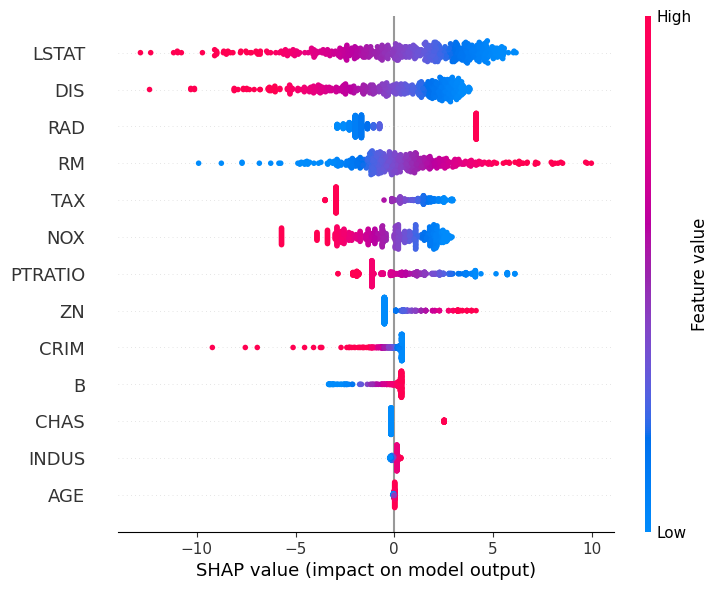

In [38]:
shap.plots.beeswarm(shap_values, max_display=20)

The above plot shows the feature importance of a linear model where the variables are ranked in
descending order and the horizontal location shows whether the effect of that value is associated
with a higher or lower prediction.
- Color shows whether that variable is high (in red) or low (in blue) for that observation.
- A high level has a high and positive impact on the quality rating.

In [39]:
# Filter selected features
X_method5 = X[['LSTAT', 'DIS', 'RM', 'PTRATIO', 'CRIM']]

In [40]:
# fit/train model
pipe.fit(X_method5, y)
# predict labels
y_pred = pipe.predict(X_method5)
print(y_pred[:10])
print(f'R^2: {pipe.score(X_method5, y):0.4}')

[31.63761273 25.5236182  32.0243847  30.38600726 29.5358719  26.50795486
 23.71933951 19.96956586 10.8068779  20.1215183 ]
R^2: 0.6958


Given the boston housing dataset is a processed data, there seems to be no improvement in the
score on feature reduction.

## Exercise 2 ##
Create a custom transformer that replaces outlier values of 1, 5, 20, 60 and 120 days SPX percentage
returns. Determine the lower and upper bound of acceptable values based on the q-th percentile.
Compare the result with the original feature set. Use the SPX dataset used in the Python Labs.

In [41]:
# Import Base and Transformer classes
from sklearn.base import BaseEstimator, TransformerMixin

We will now specify the percentiles for the lower and upper bound and define our fit method that
calculates values required to transform the outlier values.

In [42]:
# Create custom transformer class by inheriting base and additional classes
class OutlierTransform(BaseEstimator, TransformerMixin):
    def __init__(self, q_lower, q_upper):
        self.q_lower = q_lower
        self.q_upper = q_upper
    
    def fit(self, X, y=None):
        self.lower = np.percentile(X, self.q_lower, axis=0)
        self.upper = np.percentile(X, self.q_upper, axis=0)
        return self
    
    def transform(self, X):
        Xt = X.copy()
        idx_lower = X < self.lower
        idx_upper = X > self.upper
        
        for i in range(X.shape[1]):
            Xt[idx_lower[:,i], i] = self.lower[i]
            Xt[idx_upper[:,i], i] = self.upper[i]
        return Xt

In [43]:
# Load the CSV file
spx = pd.read_excel('./SP500_VaR.xlsx', index_col=0, parse_dates=True)['2015':]

In [44]:
spx.head()

,Closing Price
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893


In [45]:
rdict = {str(i)+'D_RET': spx['Closing Price'].pct_change(i) for i in [1,5,20,60,120]}

In [46]:
rdf = pd.DataFrame(rdict).dropna()

In [47]:
rdf.head()

,1D_RET,5D_RET,20D_RET,60D_RET,120D_RET
Date,,,,,
2015-06-25,-0.002974,-0.008924,-0.008714,0.016645,0.021431
2015-06-26,-0.000390,-0.004028,-0.002800,0.020294,0.040043
2015-06-29,-0.020866,-0.030718,-0.025614,-0.004509,0.027479
2015-06-30,0.002658,-0.028759,-0.022037,-0.008416,0.018367
2015-07-01,0.006936,-0.014778,-0.017336,0.000525,0.007410


In [48]:
# Convert to numpy array
Xnew = rdf.values
Xnew

array([[-0.00297357, -0.00892399, -0.00871372,  0.01664507,  0.0214314 ],
       [-0.00039008, -0.00402846, -0.00279963,  0.02029434,  0.04004298],
       [-0.02086619, -0.03071823, -0.02561411, -0.00450907,  0.02747909],
       ...,
       [ 0.00639882,  0.01214701,  0.02789233,  0.06422471,  0.1083531 ],
       [ 0.00402864,  0.01542144,  0.03590698,  0.07044363,  0.10764169],
       [ 0.00703377,  0.02069173,  0.04331236,  0.07547518,  0.1154916 ]],
      shape=(639, 5))

In [49]:
# Descriptive Statistics
rdf.describe()

,1D_RET,5D_RET,20D_RET,60D_RET,120D_RET
count,639.000000,639.000000,639.000000,639.000000,639.000000
mean,0.000442,0.002067,0.008049,0.021854,0.040265
std,0.007800,0.016319,0.029599,0.046191,0.058107
min,-0.039414,-0.109356,-0.107794,-0.115602,-0.118434
25%,-0.002343,-0.004158,-0.006861,-0.003165,0.004211
50%,0.000323,0.002798,0.011257,0.032230,0.046968
75%,0.004057,0.010689,0.025189,0.052657,0.081618
max,0.039034,0.055947,0.105578,0.125533,0.182994


In [50]:
# create, fit and transform for 5 and 95 percentile
data_transform = OutlierTransform(5,95)
data_transform.fit(Xnew)

OutlierTransform(q_lower=5, q_upper=95)

In [51]:
Xt = data_transform.transform(Xnew)
Xt

array([[-0.00297357, -0.00892399, -0.00871372,  0.01664507,  0.0214314 ],
       [-0.00039008, -0.00402846, -0.00279963,  0.02029434,  0.04004298],
       [-0.01252047, -0.02377993, -0.02561411, -0.00450907,  0.02747909],
       ...,
       [ 0.00639882,  0.01214701,  0.02789233,  0.06422471,  0.1083531 ],
       [ 0.00402864,  0.01542144,  0.03590698,  0.07044363,  0.10764169],
       [ 0.00703377,  0.02069173,  0.04331236,  0.07547518,  0.1154916 ]],
      shape=(639, 5))

In [52]:
# Transformed Data
pd.DataFrame(Xt).describe()

,0,1,2,3,4
count,639.000000,639.000000,639.000000,639.000000,639.000000
mean,0.000556,0.002485,0.007871,0.021607,0.040235
std,0.006147,0.012318,0.025193,0.042920,0.053739
min,-0.012520,-0.023780,-0.053912,-0.075603,-0.073639
25%,-0.002343,-0.004158,-0.006861,-0.003165,0.004211
50%,0.000323,0.002798,0.011257,0.032230,0.046968
75%,0.004057,0.010689,0.025189,0.052657,0.081618
max,0.013183,0.025637,0.047613,0.080264,0.121977


In [53]:
# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt
# Plot settings
import seaborn as sns
sns.set()

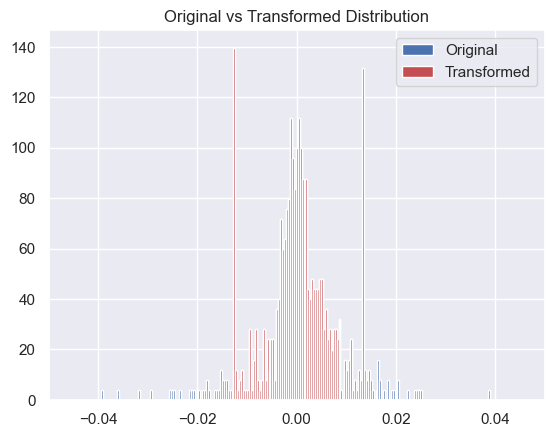

In [54]:
# Plot historgram of 1day returns
_, bins, _ = plt.hist(Xnew[:,0], density=True, bins=200, alpha=1, color='b',label = 'Original')
plt.hist(Xt[:,0], density=True, bins=bins, alpha=1, color='r', label ='Transformed')
# Set title
plt.title('Original vs Transformed Distribution')
# Set x and y axis limits
plt.xlim(-0.05, 0.05)
# Set legends
plt.legend();